IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import*

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Dropout, SpatialDropout1D, Embedding
from keras.metrics import Precision, Recall
from keras.optimizers import SGD, RMSprop
from keras import datasets
from keras.callbacks import LearningRateScheduler, History
from keras import losses
from keras.models import load_model
import keras.backend as kb

import pickle

In [2]:
df = pd.read_csv('gold-dataset-sinha-khandait.csv')

# EXLORATORY DATA ANALYSIS

**Data Cleaning and dataset preparation**

In [3]:
df

,Dates,URL,News,Price Direction Up,Price Direction Constant,Price Direction Down,Asset Comparision,Past Information,Future Information,Price Sentiment
0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1...",0,0,1,0,1,0,negative
1,13-09-2017,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline,0,0,1,0,1,0,negative
2,26-07-2016,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline,1,0,0,0,1,0,positive
3,28-02-2018,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...,0,0,0,0,0,1,none
4,06-09-2017,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers...",0,0,1,0,1,0,negative
...,...,...,...,...,...,...,...,...,...,...
10565,07-01-2013,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week,0,0,1,0,1,0,negative
10566,27-09-2018,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...,1,0,0,0,0,1,positive
10567,03-03-2017,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...,0,0,1,0,1,0,negative
10568,11-06-2008,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex,1,0,0,0,1,0,positive


The Price Sentiment column contains 4 classes (positive, neutral, negative and none)

*   Positive denotes upward movement in price
*   Negative denotes downward movement in price
*   Neutral denotes sideways (steady) movement in price
*   None denotes that no assessment about prices can be made from the news headline

In [4]:
df['Price Sentiment'].value_counts()

positive    4412
negative    3814
none        1968
neutral      376
Name: Price Sentiment, dtype: int64

In [5]:
# Removing the columns which are not required
df = df.drop(columns=['Dates', 'URL',	'Price Direction Up',	'Price Direction Constant',	'Price Direction Down',	'Asset Comparision',	'Past Information', 'Future Information'])

In [6]:
df

,News,Price Sentiment
0,"april gold down 20 cents to settle at $1,116.1...",negative
1,gold suffers third straight daily decline,negative
2,Gold futures edge up after two-session decline,positive
3,dent research : is gold's day in the sun comin...,none
4,"Gold snaps three-day rally as Trump, lawmakers...",negative
...,...,...
10565,gold seen falling from 3-week high this week,negative
10566,dominic frisby : now looks like a good time to...,positive
10567,Gold heading for worst week since November on ...,negative
10568,august gold up $7.60 at $878.80 an ounce on nymex,positive


In [7]:
# Replacing none value with neutral sentiment
df['Price Sentiment'] = df['Price Sentiment'].replace('none', 'neutral')

In [8]:
df['Price Sentiment'].value_counts()

positive    4412
negative    3814
neutral     2344
Name: Price Sentiment, dtype: int64

In [9]:
df['Price Sentiment'][12]

'positive'

In [10]:
df.isnull().sum()

News               0
Price Sentiment    0
dtype: int64

**Data Visualization**

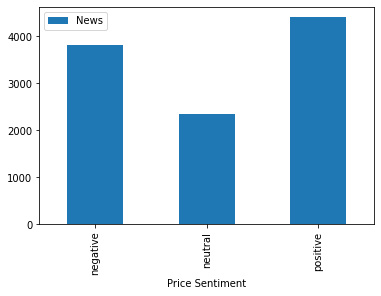

In [11]:
df.groupby('Price Sentiment').count().plot(kind='bar')
plt.show()

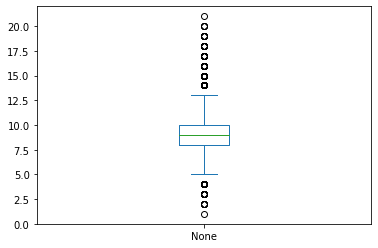

In [12]:
# Calculating review lengths
review_len = pd.Series([len(review.split()) for review in df['News']])

# Distribution of review text lengths
review_len.plot(kind='box')
plt.show()

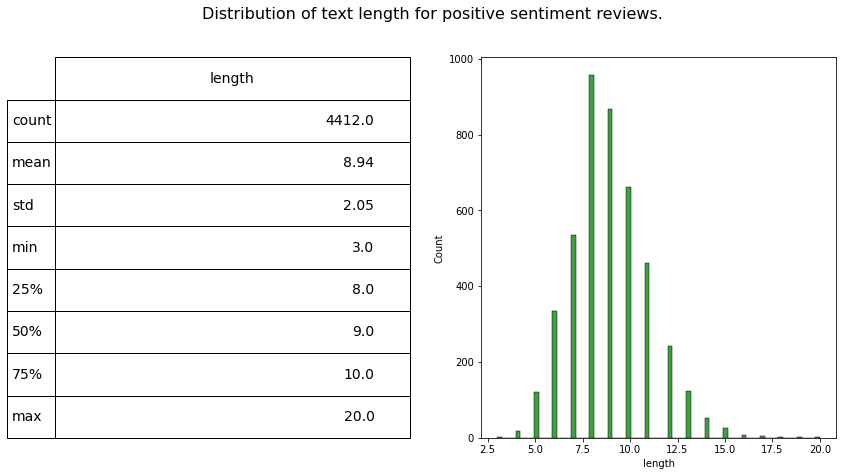

In [13]:
#Plotting the distribution of text length for positive sentiment reviews

fig = plt.figure(figsize=(14,7))
df['length'] = df.News.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Price Sentiment']=='positive']['length'], ax=ax1,color='green')
describe = df.length[df['Price Sentiment']=='positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

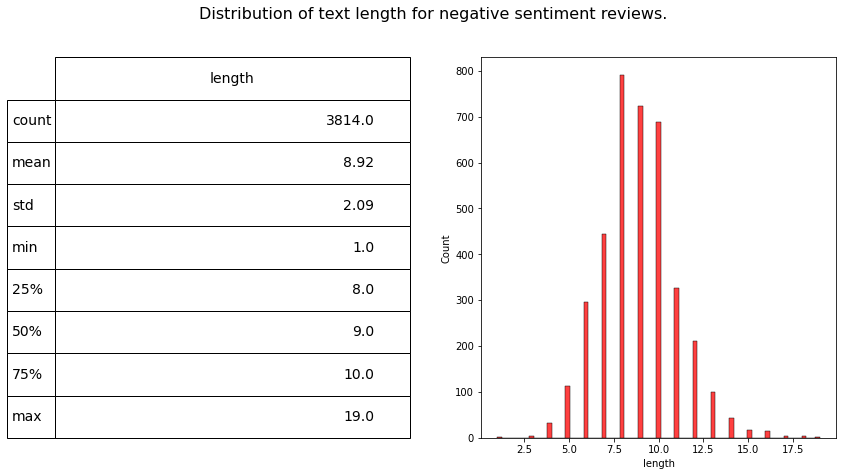

In [14]:
#Plotting the distribution of text length for negative sentiment reviews

fig = plt.figure(figsize=(14,7))
df['length'] = df.News.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Price Sentiment']=='negative']['length'], ax=ax1,color='red')
describe = df.length[df['Price Sentiment']=='negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment reviews.', fontsize=16)

plt.show()

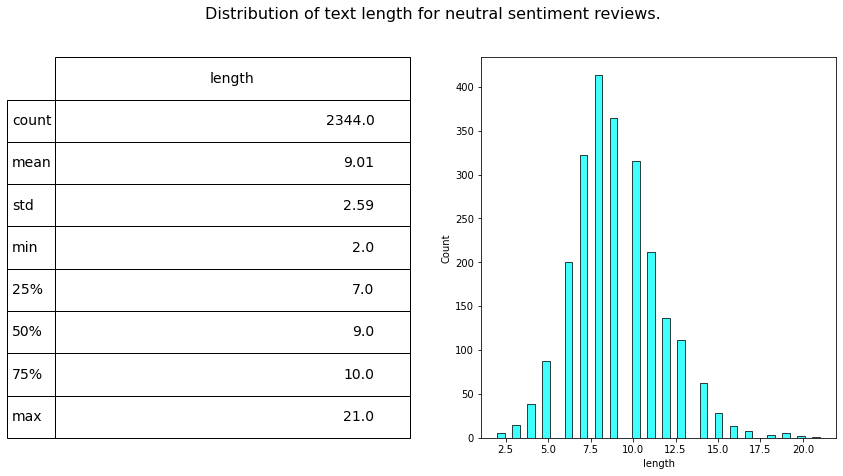

In [15]:
#Plotting the distribution of text length for neutral sentiment reviews

fig = plt.figure(figsize=(14,7))
df['length'] = df.News.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Price Sentiment']=='neutral']['length'], ax=ax1,color='cyan')
describe = df.length[df['Price Sentiment']=='neutral'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral sentiment reviews.', fontsize=16)

plt.show()

In [16]:
import plotly.express as px
fig = px.pie(df, names='Price Sentiment', title ='Pie chart of different sentiments of reviews')
fig.show()

In [17]:
df = df.drop(columns=['length'])
df[:10]

,News,Price Sentiment
0,"april gold down 20 cents to settle at $1,116.1...",negative
1,gold suffers third straight daily decline,negative
2,Gold futures edge up after two-session decline,positive
3,dent research : is gold's day in the sun comin...,neutral
4,"Gold snaps three-day rally as Trump, lawmakers...",negative
5,"Dec. gold climbs $9.40, or 0.7%, to settle at ...",positive
6,"gold falls by rs 25 on sluggish demand, global...",negative
7,"Gold futures fall for the session, but gain fo...",positive
8,"Gold struggles; silver slides, base metals falter",neutral
9,"april gold holds slight gain, up $2.50, or 0.2...",positive


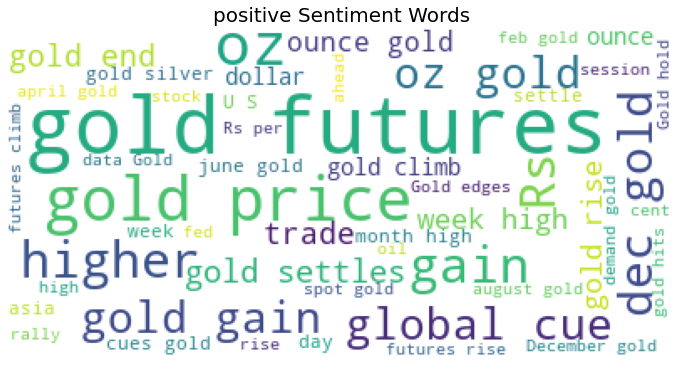

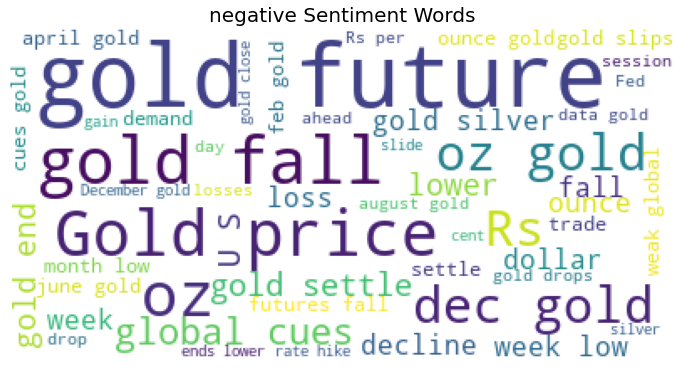

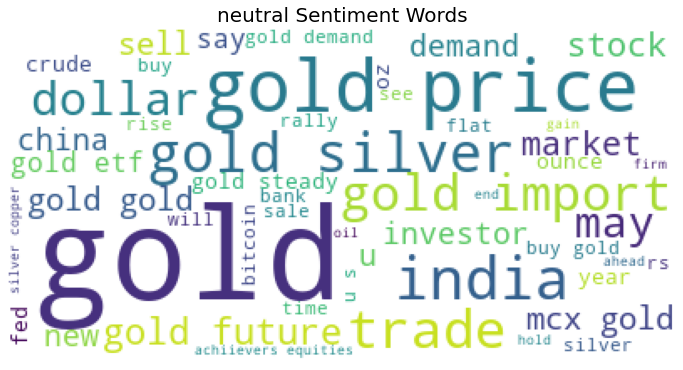

In [18]:
'''Data Visualization using WordClouds'''

def wordcount(df, rating):

  # Combining all reviews
  combined_reviews = " ".join([review for review in df[df['Price Sentiment']==rating]['News']])

  # Initializing wordcloud object
  wc = WordCloud(background_color='white', max_words=50, stopwords=STOPWORDS)

  # Generating and plotting word cloud
  plt.figure(figsize=(12,12))
  plt.imshow(wc.generate(combined_reviews))
  plt.title('{} Sentiment Words'.format(rating), fontsize=20)
  plt.axis('off')
  plt.show()

# Positive
wordcount(df, 'positive')

# Negative
wordcount(df, 'negative')

# Neutral
wordcount(df, 'neutral')

# DATA PREPROCESSING

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords

def clean_review(review):
  # Converting to lower case
  text = review.lower()

  # Removing punctuations and numeric data
  text = re.sub(r"[^a-zA-Z0-9]", " ", text)

  # Tokenize
  words = text.split()

  # Removing stopwords
  words = [w for w in words if w not in stopwords.words('english')]

  # Stemming
  words = [PorterStemmer().stem(w) for w in words]

  # Return the list
  return words

print("\nOriginal Sentiment : ", df['News'][4])
print("\nProcessed Sentiment : ", clean_review(df['News'][4]))


Original Sentiment :  Gold snaps three-day rally as Trump, lawmakers reach debt-ceiling deal

Processed Sentiment :  ['gold', 'snap', 'three', 'day', 'ralli', 'trump', 'lawmak', 'reach', 'debt', 'ceil', 'deal']


In [21]:
# Applying data processing to each review
X = list(map(clean_review, df['News']))

In [22]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['Price Sentiment'])

In [23]:
print(X[3])
print(Y[3])

['dent', 'research', 'gold', 'day', 'sun', 'come', 'soon']
1


In [24]:
'''df['Price Sentiment'] = df['Price Sentiment'].replace('positive', 1)
#.astype('string').str.replace('27', '00').astype('int64')
df['Price Sentiment'] = df['Price Sentiment'].replace('neutral', 0)
df['Price Sentiment'] = df['Price Sentiment'].replace('negative', -1)
df[:10]'''

"df['Price Sentiment'] = df['Price Sentiment'].replace('positive', 1)\n#.astype('string').str.replace('27', '00').astype('int64')\ndf['Price Sentiment'] = df['Price Sentiment'].replace('neutral', 0)\ndf['Price Sentiment'] = df['Price Sentiment'].replace('negative', -1)\ndf[:10]"

Train and Test Split

In [25]:
y = pd.get_dummies(df['Price Sentiment']) # Converting categorical variables into indicator variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

Bag Of Words feature extraction

In [26]:
vocab_size = 2000

In [27]:
tf_idfvectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True, preprocessor=lambda x: x,
                               tokenizer=lambda x: x) #(max_features=vocab_size, preprocessor=lambda x: x,
                                                      # tokenizer=lambda x: x) # ngram_range=(1,2) unigram and bigram

X_train = tf_idfvectorizer.fit_transform(X_train) #.toarray()

X_test = tf_idfvectorizer.transform(X_test) #.toarray()

In [28]:
#import sklearn.preprocessing as pr

''' Normalizing BoW features in training and test set'''
#X_train = pr.normalize(X_train, axis=1)
#X_test = pr.normalize(X_test, axis=1)

' Normalizing BoW features in training and test set'

In [29]:
# printing first 200 words/tokens
print(tf_idfvectorizer.get_feature_names_out()[0:200])

['0' '00' '000' '003' '004' '005' '007' '008' '01' '012' '015' '016' '017'
 '02' '022' '026' '027' '028' '029' '03' '030' '034' '035' '036' '04'
 '040' '045' '048' '05' '050' '052' '053' '054' '055' '06' '060' '064'
 '068' '07' '070' '073' '078' '08' '080' '084' '085' '090' '091' '093'
 '094' '095' '096' '097' '098' '1' '10' '100' '1000' '102' '103' '105'
 '106' '107' '108' '109' '10c' '10g' '10gm' '10k' '10th' '11' '110' '111'
 '112' '114' '115' '1150am' '116' '1173' '1183' '1187' '1191' '1199' '12'
 '120' '1200' '1204' '121' '1214' '1215' '1217' '1228' '123' '1236' '124'
 '1240' '1243' '125' '1250' '126' '127' '1270' '1275' '128' '129' '13'
 '130' '1300' '131' '132' '1320' '133' '134' '1347' '135' '1350' '136'
 '1360' '1361' '137' '138' '1386' '139' '13f' '13th' '14' '140' '1400'
 '141' '142' '143' '144' '145' '1450' '148' '149' '15' '150' '151' '152'
 '1522' '153' '1530' '155' '156' '1585' '159' '16' '160' '1600' '161'
 '162' '1620' '163' '1630' '164' '165' '166' '1664' '167' '1680'

Tokenizing and Padding

In [30]:
# Tokenize the input text into integers and pad each sequence to the same length

max_len = 25

def tokenize_pad_seq(text):
  # Tokenizing text
  tokenizer = Tokenizer(num_words=5000, lower=True, split=' ')
  tokenizer.fit_on_texts(text) 

  X = tokenizer.texts_to_sequences(text) # Text to sequence of integers
  X = pad_sequences(X, padding='post', maxlen=max_len) # Pad sequences to same length

  return X, tokenizer

print('Before :\n ', df['News'][12])
X, tokenizer = tokenize_pad_seq(df['News'])
print('After :\n ', X[12])

Before :
  gold loses 1.3%, but logs monthly gain of 6.3%
After :
  [  1 195   2  32  62 280 355  45  19  59  32   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]


In [31]:
#Saving the processed data

with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer,handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

In [32]:
y = pd.get_dummies(df['Price Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

print('Train set : ', X_train.shape, y_train.shape)
print('Validation set : ', X_val.shape, y_val.shape)
print('Test set : ', X_test.shape, y_test.shape)

Train set :  (8561, 25) (8561, 3)
Validation set :  (952, 25) (952, 3)
Test set :  (1057, 25) (1057, 3)


In [33]:
def f1_score(precision, recall):
  f1_val = 2*(precision*recall)/(precision+recall+kb.epsilon()) # Calculating F1 score
  return f1_val

# BIDIRECTIONAL LSTM MODEL

In [34]:
from tensorflow.keras import regularizers

embedding_size = 32
learning_rate = 0.1

#BUILD
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(SpatialDropout1D(0.25))
model.add(MaxPooling1D(pool_size=3))
model.add(Bidirectional(LSTM(50, dropout=0.5, kernel_regularizer = regularizers.l2(1e-6))))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

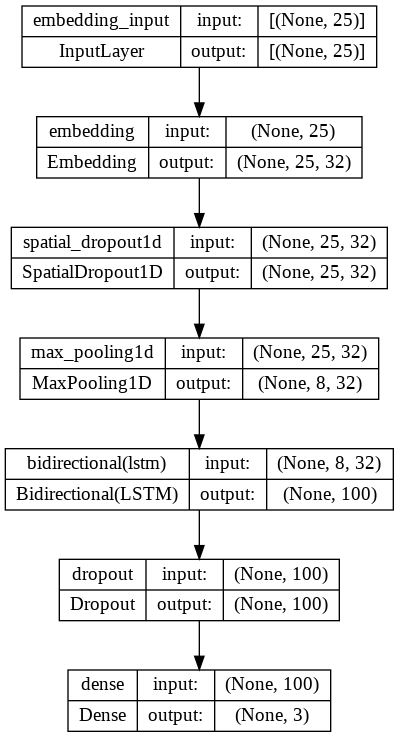

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [36]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 32)            64000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 32)           0         
 ropout1D)                                                       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 32)            0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 100)              33200     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                        

Training the model

In [37]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=10, verbose =1, shuffle=True)

Epoch 1/10
241/241 [==============================] - 8s 13ms/step - loss: 0.9024 - accuracy: 0.5500 - precision: 0.7590 - recall: 0.2699 - val_loss: 0.4524 - val_accuracy: 0.8436 - val_precision: 0.8791 - val_recall: 0.7888
Epoch 2/10
241/241 [==============================] - 2s 9ms/step - loss: 0.4145 - accuracy: 0.8567 - precision: 0.8805 - recall: 0.8302 - val_loss: 0.3003 - val_accuracy: 0.8915 - val_precision: 0.9033 - val_recall: 0.8833
Epoch 3/10
241/241 [==============================] - 2s 9ms/step - loss: 0.3077 - accuracy: 0.8986 - precision: 0.9098 - recall: 0.8873 - val_loss: 0.2785 - val_accuracy: 0.9067 - val_precision: 0.9134 - val_recall: 0.8985
Epoch 4/10
241/241 [==============================] - 2s 8ms/step - loss: 0.2519 - accuracy: 0.9120 - precision: 0.9202 - recall: 0.9042 - val_loss: 0.2771 - val_accuracy: 0.9067 - val_precision: 0.9125 - val_recall: 0.9008
Epoch 5/10
241/241 [==============================] - 2s 8ms/step - loss: 0.2188 - accuracy: 0.9245 - p

# EVALUATING RESULTS

In [38]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('Accuracy : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall : {:.4f}'.format(recall))
print('F1 Score : {:.4f}'.format(f1_score(precision, recall)))

Accuracy : 0.8865
Precision : 0.8922
Recall : 0.8846
F1 Score : 0.8884


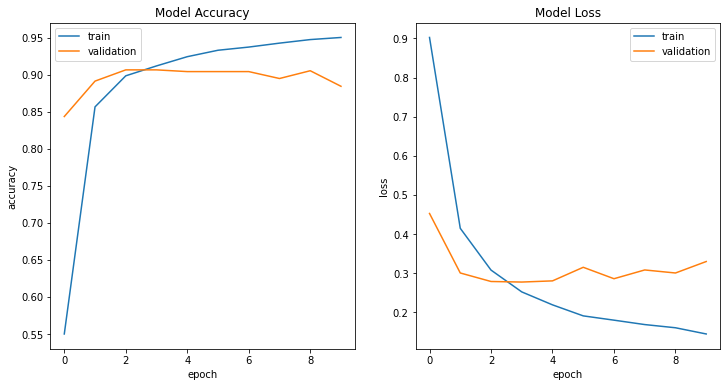

In [39]:
# Function to accuracy and loss

def plot_training_hist(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

34/34 [==============================] - 1s 3ms/step


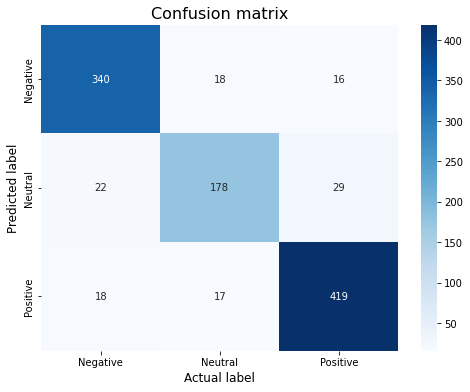

In [40]:
# Plotting confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

Save and load the model for prediction

In [41]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Model saved')

Model saved


In [42]:
# Function to predict sentiment class of the passed text

def predict_class(text):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=25
    
    # Transform text to a sequence of integers using a tokenizer object
    tw = tokenizer.texts_to_sequences([text])
    # Pad sequences to the same length
    tw = pad_sequences(tw, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    pred = model.predict(tw).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[pred[0]])

In [43]:
predict_class('Gold futures edge up after two-session decline')

1/1 [==============================] - 0s 16ms/step
The predicted sentiment is Positive


In [44]:
predict_class('The price of gold continues to decline.')

1/1 [==============================] - 0s 18ms/step
The predicted sentiment is Negative


In [45]:
predict_class('Gold price expected to remain steady.')

1/1 [==============================] - 0s 14ms/step
The predicted sentiment is Neutral


In [46]:
predict_class('gold silver decline on lower offtake.')

1/1 [==============================] - 0s 15ms/step
The predicted sentiment is Negative
